In [8]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision import transforms
import numpy as np
import time
import matplotlib.pyplot as plt

In [277]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(252, 126), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(126, 63),
            nn.ReLU(),
            nn.Linear(63, 12)
        )
        
        
        self.z_mean = torch.nn.Linear(12, 2)
        self.z_log_var = torch.nn.Linear(12, 2)
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(),
            nn.Linear(12, 63),
            nn.ReLU(),
            nn.Linear(63, 126),
            nn.ReLU(),
            nn.Linear(126, 252),
            nn.Tanh()
        )
        
        
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.rand_like(z_mu)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
    
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded


In [278]:
## Traing the model

def train_vae_v1(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100, 
                 skip_epoch_stats=False,
                 reconstruction_term_weight=1,
                 save_model=None):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    
    for epoch in range(num_epochs):

        model.train()
        
        for batch_idx, features in enumerate(train_loader):

            features = features.to(device)

            # FORWARD AND BACK PROP
            encoded, z_mean, z_log_var, decoded = model(features)
            
            # total loss = reconstruction loss + KL divergence
            #kl_divergence = (0.5 * (z_mean**2 + 
            #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
            kl_div = -0.5 * torch.sum(1 + z_log_var 
                                      - z_mean**2 
                                      - torch.exp(z_log_var), 
                                      axis=1) # sum over latent dimension

            batchsize = kl_div.size(0)
            kl_div = kl_div.mean() # average over batch dimension
    
            pixelwise = loss_fn(decoded, features, reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            pixelwise = pixelwise.mean() # average over batch dimension
            
            loss = reconstruction_term_weight*pixelwise + kl_div
            
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict, model

In [279]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()
    
    


In [280]:
def runing_model(data_plot,model=vae):
    laten=[]
    recreat=[]
    for i in data_plot:
        z_no = model.encoding_fn(i)
        laten.append(z_no.detach().numpy())
        input_recr = model.decoder(z_no)
        
        recreat.append(input_recr.detach().numpy())
        
    return np.array(laten), np.array(recreat)

In [281]:
import random
import torch
import numpy as np
import os


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)
    
    
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [9]:
## Data Loading

angles_300=np.load('angles_all/A_300.0.npy')
angles_320=np.load('angles_all/A_322.104.npy')
angles_350=np.load('angles_all/A_352.038.npy')
angles_390=np.load('angles_all/A_391.654.npy')
angles_400=np.load('angles_all/A_405.826.npy')

angles_450=np.load('angles_all/A_451.494.npy')

angles_500=np.load('angles_all/A_502.301.npy')

angles_550=np.load('angles_all/A_558.826.npy')

angles_600=np.load('angles_all/A_600.0.npy')

angles=np.concatenate((angles_300, angles_320,angles_350,angles_390,angles_400,angles_450,
                      angles_500,angles_550,angles_600), axis=0)



In [10]:
## Make data into tensor

transform = transforms.ToTensor()
data = torch.utils.data.DataLoader(dataset=angles,
                                          batch_size=2000,
                                          shuffle=True)

In [9]:
len(data)

208

In [285]:
angles.shape

(414125, 252)

In [286]:
# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 276

Device: cpu


In [287]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [288]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [289]:
for images in data:  
    print('Image batch dimensions:', images.size())

    print(images[:10])
    break


Image batch dimensions: torch.Size([1500, 252])
tensor([[-0.9123, -0.9984,  0.4555,  ..., -0.0529,  0.0175, -0.0234],
        [ 0.2686, -0.9870,  0.8603,  ..., -0.0459,  0.0226, -0.0138],
        [-0.1698, -0.9953, -0.9910,  ..., -0.0274, -0.0250,  0.0111],
        ...,
        [ 0.3902, -0.9988,  0.5034,  ..., -0.0248,  0.0233, -0.0246],
        [-0.1391, -0.9867,  0.8134,  ..., -0.0409, -0.0211, -0.0212],
        [ 0.1145, -0.9256,  0.7284,  ..., -0.0475, -0.0184, -0.0436]])


In [290]:
log_dict,vae = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=data,
                        skip_epoch_stats=True,
                        logging_interval=50,
                           save_model='try.pth')

Epoch: 001/276 | Batch 0000/0277 | Loss: 55.9215
Epoch: 001/276 | Batch 0050/0277 | Loss: 34.6877
Epoch: 001/276 | Batch 0100/0277 | Loss: 32.4485
Epoch: 001/276 | Batch 0150/0277 | Loss: 31.0950
Epoch: 001/276 | Batch 0200/0277 | Loss: 29.8346
Epoch: 001/276 | Batch 0250/0277 | Loss: 28.2710
Time elapsed: 0.03 min
Epoch: 002/276 | Batch 0000/0277 | Loss: 27.9522
Epoch: 002/276 | Batch 0050/0277 | Loss: 28.2819
Epoch: 002/276 | Batch 0100/0277 | Loss: 27.6418
Epoch: 002/276 | Batch 0150/0277 | Loss: 27.4724
Epoch: 002/276 | Batch 0200/0277 | Loss: 26.9400
Epoch: 002/276 | Batch 0250/0277 | Loss: 27.2856
Time elapsed: 0.06 min
Epoch: 003/276 | Batch 0000/0277 | Loss: 26.7839
Epoch: 003/276 | Batch 0050/0277 | Loss: 26.8002
Epoch: 003/276 | Batch 0100/0277 | Loss: 26.6601
Epoch: 003/276 | Batch 0150/0277 | Loss: 26.0094
Epoch: 003/276 | Batch 0200/0277 | Loss: 26.4885
Epoch: 003/276 | Batch 0250/0277 | Loss: 26.3879
Time elapsed: 0.09 min
Epoch: 004/276 | Batch 0000/0277 | Loss: 26.6817


Epoch: 027/276 | Batch 0050/0277 | Loss: 25.2137
Epoch: 027/276 | Batch 0100/0277 | Loss: 24.8004
Epoch: 027/276 | Batch 0150/0277 | Loss: 25.0813
Epoch: 027/276 | Batch 0200/0277 | Loss: 24.9872
Epoch: 027/276 | Batch 0250/0277 | Loss: 25.6442
Time elapsed: 0.81 min
Epoch: 028/276 | Batch 0000/0277 | Loss: 25.0567
Epoch: 028/276 | Batch 0050/0277 | Loss: 25.0724
Epoch: 028/276 | Batch 0100/0277 | Loss: 25.4254
Epoch: 028/276 | Batch 0150/0277 | Loss: 25.2134
Epoch: 028/276 | Batch 0200/0277 | Loss: 25.0022
Epoch: 028/276 | Batch 0250/0277 | Loss: 25.0649
Time elapsed: 0.84 min
Epoch: 029/276 | Batch 0000/0277 | Loss: 24.9751
Epoch: 029/276 | Batch 0050/0277 | Loss: 25.0778
Epoch: 029/276 | Batch 0100/0277 | Loss: 25.1375
Epoch: 029/276 | Batch 0150/0277 | Loss: 25.0403
Epoch: 029/276 | Batch 0200/0277 | Loss: 25.1391
Epoch: 029/276 | Batch 0250/0277 | Loss: 25.0480
Time elapsed: 0.87 min
Epoch: 030/276 | Batch 0000/0277 | Loss: 25.4159
Epoch: 030/276 | Batch 0050/0277 | Loss: 24.8138


Epoch: 053/276 | Batch 0050/0277 | Loss: 24.3939
Epoch: 053/276 | Batch 0100/0277 | Loss: 24.7996
Epoch: 053/276 | Batch 0150/0277 | Loss: 24.6590
Epoch: 053/276 | Batch 0200/0277 | Loss: 24.6037
Epoch: 053/276 | Batch 0250/0277 | Loss: 24.7241
Time elapsed: 1.60 min
Epoch: 054/276 | Batch 0000/0277 | Loss: 24.9580
Epoch: 054/276 | Batch 0050/0277 | Loss: 24.4945
Epoch: 054/276 | Batch 0100/0277 | Loss: 24.7272
Epoch: 054/276 | Batch 0150/0277 | Loss: 24.5728
Epoch: 054/276 | Batch 0200/0277 | Loss: 24.6256
Epoch: 054/276 | Batch 0250/0277 | Loss: 25.0268
Time elapsed: 1.63 min
Epoch: 055/276 | Batch 0000/0277 | Loss: 24.8033
Epoch: 055/276 | Batch 0050/0277 | Loss: 24.9596
Epoch: 055/276 | Batch 0100/0277 | Loss: 24.5742
Epoch: 055/276 | Batch 0150/0277 | Loss: 24.7976
Epoch: 055/276 | Batch 0200/0277 | Loss: 25.1522
Epoch: 055/276 | Batch 0250/0277 | Loss: 24.6143
Time elapsed: 1.65 min
Epoch: 056/276 | Batch 0000/0277 | Loss: 24.7619
Epoch: 056/276 | Batch 0050/0277 | Loss: 24.6412


Epoch: 079/276 | Batch 0050/0277 | Loss: 25.1929
Epoch: 079/276 | Batch 0100/0277 | Loss: 24.4788
Epoch: 079/276 | Batch 0150/0277 | Loss: 24.5805
Epoch: 079/276 | Batch 0200/0277 | Loss: 24.6305
Epoch: 079/276 | Batch 0250/0277 | Loss: 24.5004
Time elapsed: 2.38 min
Epoch: 080/276 | Batch 0000/0277 | Loss: 24.9599
Epoch: 080/276 | Batch 0050/0277 | Loss: 24.8269
Epoch: 080/276 | Batch 0100/0277 | Loss: 23.9506
Epoch: 080/276 | Batch 0150/0277 | Loss: 24.7155
Epoch: 080/276 | Batch 0200/0277 | Loss: 24.8141
Epoch: 080/276 | Batch 0250/0277 | Loss: 24.9500
Time elapsed: 2.41 min
Epoch: 081/276 | Batch 0000/0277 | Loss: 24.4732
Epoch: 081/276 | Batch 0050/0277 | Loss: 23.9934
Epoch: 081/276 | Batch 0100/0277 | Loss: 24.7655
Epoch: 081/276 | Batch 0150/0277 | Loss: 24.4474
Epoch: 081/276 | Batch 0200/0277 | Loss: 24.4125
Epoch: 081/276 | Batch 0250/0277 | Loss: 24.3969
Time elapsed: 2.43 min
Epoch: 082/276 | Batch 0000/0277 | Loss: 24.5269
Epoch: 082/276 | Batch 0050/0277 | Loss: 24.4292


Epoch: 105/276 | Batch 0050/0277 | Loss: 24.9283
Epoch: 105/276 | Batch 0100/0277 | Loss: 24.7894
Epoch: 105/276 | Batch 0150/0277 | Loss: 24.1785
Epoch: 105/276 | Batch 0200/0277 | Loss: 24.1121
Epoch: 105/276 | Batch 0250/0277 | Loss: 24.4780
Time elapsed: 3.15 min
Epoch: 106/276 | Batch 0000/0277 | Loss: 25.1920
Epoch: 106/276 | Batch 0050/0277 | Loss: 24.5128
Epoch: 106/276 | Batch 0100/0277 | Loss: 24.8124
Epoch: 106/276 | Batch 0150/0277 | Loss: 24.2947
Epoch: 106/276 | Batch 0200/0277 | Loss: 24.1162
Epoch: 106/276 | Batch 0250/0277 | Loss: 24.2888
Time elapsed: 3.18 min
Epoch: 107/276 | Batch 0000/0277 | Loss: 24.7034
Epoch: 107/276 | Batch 0050/0277 | Loss: 24.3383
Epoch: 107/276 | Batch 0100/0277 | Loss: 24.6653
Epoch: 107/276 | Batch 0150/0277 | Loss: 24.2562
Epoch: 107/276 | Batch 0200/0277 | Loss: 24.7252
Epoch: 107/276 | Batch 0250/0277 | Loss: 24.5802
Time elapsed: 3.21 min
Epoch: 108/276 | Batch 0000/0277 | Loss: 24.6442
Epoch: 108/276 | Batch 0050/0277 | Loss: 24.5670


Epoch: 131/276 | Batch 0050/0277 | Loss: 23.6567
Epoch: 131/276 | Batch 0100/0277 | Loss: 24.3309
Epoch: 131/276 | Batch 0150/0277 | Loss: 24.3732
Epoch: 131/276 | Batch 0200/0277 | Loss: 24.2032
Epoch: 131/276 | Batch 0250/0277 | Loss: 23.9836
Time elapsed: 3.94 min
Epoch: 132/276 | Batch 0000/0277 | Loss: 24.5251
Epoch: 132/276 | Batch 0050/0277 | Loss: 24.5155
Epoch: 132/276 | Batch 0100/0277 | Loss: 24.4980
Epoch: 132/276 | Batch 0150/0277 | Loss: 24.3662
Epoch: 132/276 | Batch 0200/0277 | Loss: 24.6732
Epoch: 132/276 | Batch 0250/0277 | Loss: 24.8258
Time elapsed: 3.97 min
Epoch: 133/276 | Batch 0000/0277 | Loss: 23.8316
Epoch: 133/276 | Batch 0050/0277 | Loss: 24.3225
Epoch: 133/276 | Batch 0100/0277 | Loss: 23.4575
Epoch: 133/276 | Batch 0150/0277 | Loss: 24.1987
Epoch: 133/276 | Batch 0200/0277 | Loss: 24.5836
Epoch: 133/276 | Batch 0250/0277 | Loss: 24.7838
Time elapsed: 4.00 min
Epoch: 134/276 | Batch 0000/0277 | Loss: 24.2897
Epoch: 134/276 | Batch 0050/0277 | Loss: 24.3087


Epoch: 157/276 | Batch 0050/0277 | Loss: 24.0781
Epoch: 157/276 | Batch 0100/0277 | Loss: 23.8553
Epoch: 157/276 | Batch 0150/0277 | Loss: 24.2907
Epoch: 157/276 | Batch 0200/0277 | Loss: 24.7204
Epoch: 157/276 | Batch 0250/0277 | Loss: 24.0197
Time elapsed: 4.72 min
Epoch: 158/276 | Batch 0000/0277 | Loss: 24.5621
Epoch: 158/276 | Batch 0050/0277 | Loss: 23.9871
Epoch: 158/276 | Batch 0100/0277 | Loss: 24.2524
Epoch: 158/276 | Batch 0150/0277 | Loss: 24.1339
Epoch: 158/276 | Batch 0200/0277 | Loss: 23.9781
Epoch: 158/276 | Batch 0250/0277 | Loss: 23.9613
Time elapsed: 4.75 min
Epoch: 159/276 | Batch 0000/0277 | Loss: 24.5613
Epoch: 159/276 | Batch 0050/0277 | Loss: 24.0438
Epoch: 159/276 | Batch 0100/0277 | Loss: 24.3893
Epoch: 159/276 | Batch 0150/0277 | Loss: 23.9519
Epoch: 159/276 | Batch 0200/0277 | Loss: 24.6981
Epoch: 159/276 | Batch 0250/0277 | Loss: 23.9543
Time elapsed: 4.78 min
Epoch: 160/276 | Batch 0000/0277 | Loss: 24.2284
Epoch: 160/276 | Batch 0050/0277 | Loss: 24.0526


Epoch: 183/276 | Batch 0050/0277 | Loss: 24.0990
Epoch: 183/276 | Batch 0100/0277 | Loss: 24.3579
Epoch: 183/276 | Batch 0150/0277 | Loss: 24.4887
Epoch: 183/276 | Batch 0200/0277 | Loss: 24.4524
Epoch: 183/276 | Batch 0250/0277 | Loss: 24.1158
Time elapsed: 5.50 min
Epoch: 184/276 | Batch 0000/0277 | Loss: 24.0232
Epoch: 184/276 | Batch 0050/0277 | Loss: 23.8133
Epoch: 184/276 | Batch 0100/0277 | Loss: 24.6452
Epoch: 184/276 | Batch 0150/0277 | Loss: 23.8961
Epoch: 184/276 | Batch 0200/0277 | Loss: 23.4765
Epoch: 184/276 | Batch 0250/0277 | Loss: 24.4146
Time elapsed: 5.53 min
Epoch: 185/276 | Batch 0000/0277 | Loss: 24.4664
Epoch: 185/276 | Batch 0050/0277 | Loss: 24.6755
Epoch: 185/276 | Batch 0100/0277 | Loss: 24.5652
Epoch: 185/276 | Batch 0150/0277 | Loss: 24.4130
Epoch: 185/276 | Batch 0200/0277 | Loss: 24.4481
Epoch: 185/276 | Batch 0250/0277 | Loss: 23.9636
Time elapsed: 5.56 min
Epoch: 186/276 | Batch 0000/0277 | Loss: 24.4072
Epoch: 186/276 | Batch 0050/0277 | Loss: 24.0592


Epoch: 209/276 | Batch 0050/0277 | Loss: 24.4900
Epoch: 209/276 | Batch 0100/0277 | Loss: 24.3677
Epoch: 209/276 | Batch 0150/0277 | Loss: 24.1043
Epoch: 209/276 | Batch 0200/0277 | Loss: 23.9893
Epoch: 209/276 | Batch 0250/0277 | Loss: 24.5086
Time elapsed: 6.28 min
Epoch: 210/276 | Batch 0000/0277 | Loss: 24.0834
Epoch: 210/276 | Batch 0050/0277 | Loss: 24.4309
Epoch: 210/276 | Batch 0100/0277 | Loss: 24.3937
Epoch: 210/276 | Batch 0150/0277 | Loss: 24.8256
Epoch: 210/276 | Batch 0200/0277 | Loss: 24.3555
Epoch: 210/276 | Batch 0250/0277 | Loss: 24.4371
Time elapsed: 6.31 min
Epoch: 211/276 | Batch 0000/0277 | Loss: 24.5370
Epoch: 211/276 | Batch 0050/0277 | Loss: 24.4230
Epoch: 211/276 | Batch 0100/0277 | Loss: 24.2144
Epoch: 211/276 | Batch 0150/0277 | Loss: 24.4683
Epoch: 211/276 | Batch 0200/0277 | Loss: 23.9009
Epoch: 211/276 | Batch 0250/0277 | Loss: 23.7977
Time elapsed: 6.34 min
Epoch: 212/276 | Batch 0000/0277 | Loss: 24.2193
Epoch: 212/276 | Batch 0050/0277 | Loss: 24.0596


Epoch: 235/276 | Batch 0050/0277 | Loss: 24.1644
Epoch: 235/276 | Batch 0100/0277 | Loss: 24.2015
Epoch: 235/276 | Batch 0150/0277 | Loss: 24.3045
Epoch: 235/276 | Batch 0200/0277 | Loss: 24.2150
Epoch: 235/276 | Batch 0250/0277 | Loss: 24.4035
Time elapsed: 7.06 min
Epoch: 236/276 | Batch 0000/0277 | Loss: 24.6354
Epoch: 236/276 | Batch 0050/0277 | Loss: 23.8208
Epoch: 236/276 | Batch 0100/0277 | Loss: 23.8064
Epoch: 236/276 | Batch 0150/0277 | Loss: 23.9270
Epoch: 236/276 | Batch 0200/0277 | Loss: 24.1462
Epoch: 236/276 | Batch 0250/0277 | Loss: 23.8476
Time elapsed: 7.09 min
Epoch: 237/276 | Batch 0000/0277 | Loss: 24.8855
Epoch: 237/276 | Batch 0050/0277 | Loss: 23.5572
Epoch: 237/276 | Batch 0100/0277 | Loss: 24.0680
Epoch: 237/276 | Batch 0150/0277 | Loss: 24.1379
Epoch: 237/276 | Batch 0200/0277 | Loss: 24.6270
Epoch: 237/276 | Batch 0250/0277 | Loss: 23.8924
Time elapsed: 7.12 min
Epoch: 238/276 | Batch 0000/0277 | Loss: 23.8667
Epoch: 238/276 | Batch 0050/0277 | Loss: 24.5082


Epoch: 261/276 | Batch 0050/0277 | Loss: 24.2309
Epoch: 261/276 | Batch 0100/0277 | Loss: 24.2005
Epoch: 261/276 | Batch 0150/0277 | Loss: 24.2140
Epoch: 261/276 | Batch 0200/0277 | Loss: 23.7205
Epoch: 261/276 | Batch 0250/0277 | Loss: 24.0470
Time elapsed: 7.84 min
Epoch: 262/276 | Batch 0000/0277 | Loss: 24.1902
Epoch: 262/276 | Batch 0050/0277 | Loss: 24.1642
Epoch: 262/276 | Batch 0100/0277 | Loss: 24.3749
Epoch: 262/276 | Batch 0150/0277 | Loss: 24.1859
Epoch: 262/276 | Batch 0200/0277 | Loss: 24.4679
Epoch: 262/276 | Batch 0250/0277 | Loss: 24.3789
Time elapsed: 7.87 min
Epoch: 263/276 | Batch 0000/0277 | Loss: 25.1239
Epoch: 263/276 | Batch 0050/0277 | Loss: 24.0309
Epoch: 263/276 | Batch 0100/0277 | Loss: 24.7583
Epoch: 263/276 | Batch 0150/0277 | Loss: 23.9939
Epoch: 263/276 | Batch 0200/0277 | Loss: 24.5287
Epoch: 263/276 | Batch 0250/0277 | Loss: 24.4933
Time elapsed: 7.90 min
Epoch: 264/276 | Batch 0000/0277 | Loss: 24.2357
Epoch: 264/276 | Batch 0050/0277 | Loss: 23.5056


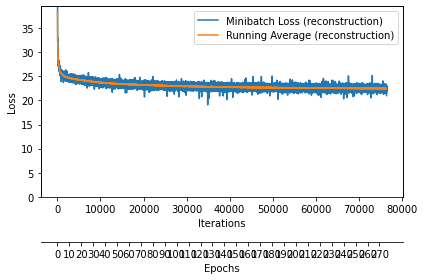

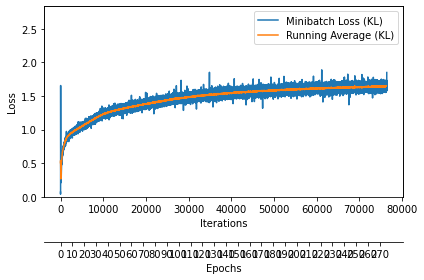

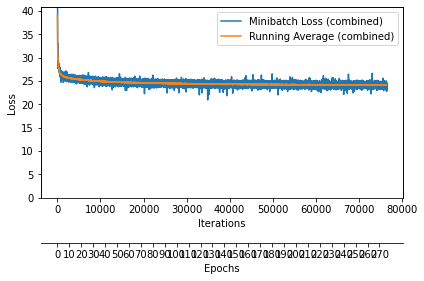

In [291]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [292]:
loaded_model = VAE()
loaded_model.load_state_dict(torch.load('try.pth')) # it takes the loaded dictionary, not the path file itself
loaded_model.eval()


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=252, out_features=126, bias=True)
    (1): ReLU()
    (2): Linear(in_features=126, out_features=63, bias=True)
    (3): ReLU()
    (4): Linear(in_features=63, out_features=12, bias=True)
  )
  (z_mean): Linear(in_features=12, out_features=2, bias=True)
  (z_log_var): Linear(in_features=12, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=63, bias=True)
    (3): ReLU()
    (4): Linear(in_features=63, out_features=126, bias=True)
    (5): ReLU()
    (6): Linear(in_features=126, out_features=252, bias=True)
    (7): Tanh()
  )
)

In [16]:
transform = transforms.ToTensor()
data_300 = torch.utils.data.DataLoader(dataset=angles_300,
                                          batch_size=1)

In [294]:

laten_300,re_300=runing_model(data_300,model=loaded_model)


<Axes: >

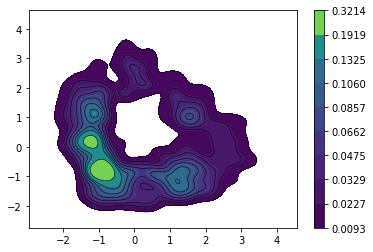

In [295]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=laten_300[:,:,0][:,0],
            y=laten_300[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=laten_300[:,:,0][:,0], 
            y=laten_300[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

<Axes: ylabel='Density'>

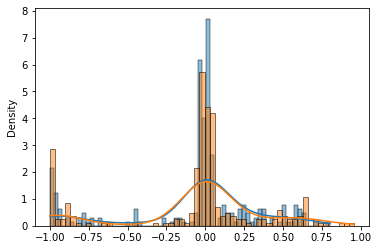

In [297]:
### Checking the match

sns.histplot(re_300[5000][0],kde=True,stat='density')
sns.histplot(angles_300[5000],kde=True,stat='density')

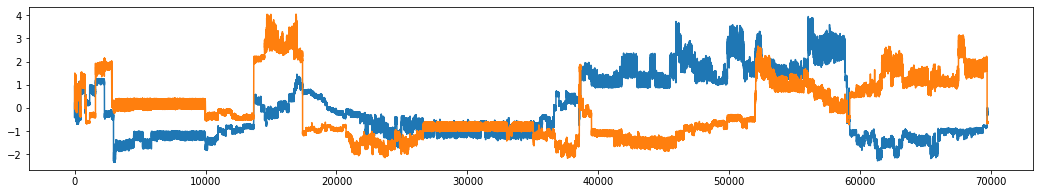

In [304]:
## Latent vector evolve

plt.figure(figsize=(18,3))
plt.plot(laten_300[:,:,0])
plt.plot(laten_300[:,:,1])


In [25]:
transform = transforms.ToTensor()
data_350 = torch.utils.data.DataLoader(dataset=angles_350,
                                          batch_size=1)

In [306]:
laten_350,re_350=runing_model(data_350,model=loaded_model)

<Axes: >

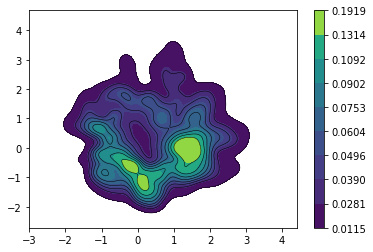

In [307]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=laten_350[:,:,0][:,0],
            y=laten_350[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=laten_350[:,:,0][:,0], 
            y=laten_350[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

In [26]:
transform = transforms.ToTensor()

data_400 = torch.utils.data.DataLoader(dataset=angles_400,
                                          batch_size=1) 
       

In [309]:
laten_400,re_400=runing_model(data_400,model=loaded_model)

<Axes: >

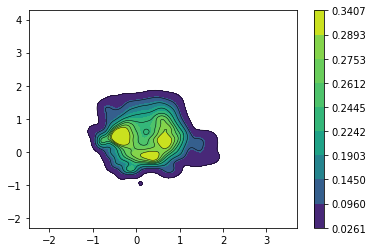

In [310]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=laten_400[:,:,0][:,0],
            y=laten_400[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=laten_400[:,:,0][:,0], 
            y=laten_400[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

In [27]:
## high temperature
ransform = transforms.ToTensor()

data_500 = torch.utils.data.DataLoader(dataset=angles_500,
                                          batch_size=1) 

In [249]:
laten_500,re_500=runing_model(data_500,model=loaded_model)

<Axes: >

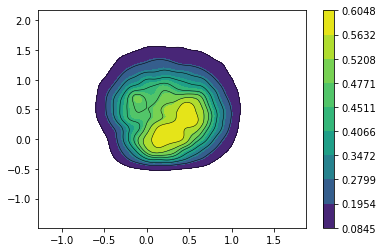

In [250]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=laten_500[:,:,0][:,0],
            y=laten_500[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=laten_500[:,:,0][:,0], 
            y=laten_500[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

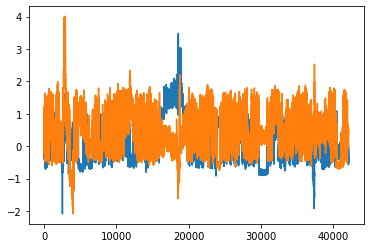

In [251]:
plt.plot(laten_400[:,:,0])
plt.plot(laten_400[:,:,1])

# Autoencoders

In [2]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision import transforms
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(252, 126)
        self.linear2 = nn.Linear(126, 63)
        self.linear3 = nn.Linear(63, 12)
        self.linear4 = nn.Linear(12, latent_dims)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        
        return self.linear4(x)
    

class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 12)
        self.linear2 = nn.Linear(12,63)
        self.linear3 = nn.Linear(63,126)
        self.linear4 = nn.Linear(126,252)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = F.relu(self.linear3(z))
        z = torch.tanh(self.linear4(z))
        return z
    
    

    

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    
    
def train(autoencoder, data, epochs=30):
    plt.figure()
    #opt = torch.optim.Adam(autoencoder.parameters())
    opt = torch.optim.Adam(autoencoder.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)
    criterion = nn.MSELoss()
    loss_gra=[]
    for epoch in range(epochs):
        for x in data:
            x = x.to(device) # GPU

            x_hat = autoencoder(x)
            #loss = ((x - x_hat)**2).sum()
            loss = criterion(x,x_hat)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_gra.append(loss.detach().numpy())
            
    plt.plot( loss_gra)
    plt.show()
    return autoencoder

In [6]:
model = Autoencoder(latent_dims=2)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

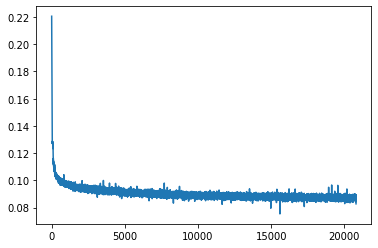

In [11]:
ae=train(model,data, epochs=100)


In [13]:
## Saving the model

torch.save(ae.state_dict(),'ae.pth')

In [15]:
## Loading ae file

loaded_ae = Autoencoder(latent_dims=2)
loaded_ae.load_state_dict(torch.load('ae.pth')) # it takes the loaded dictionary, not the path file itself
loaded_ae.eval()

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=252, out_features=126, bias=True)
    (linear2): Linear(in_features=126, out_features=63, bias=True)
    (linear3): Linear(in_features=63, out_features=12, bias=True)
    (linear4): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=12, bias=True)
    (linear2): Linear(in_features=12, out_features=63, bias=True)
    (linear3): Linear(in_features=63, out_features=126, bias=True)
    (linear4): Linear(in_features=126, out_features=252, bias=True)
  )
)

In [17]:
laten_dim=[]
angle_re=[]

for j,i in enumerate(data_300):
    laten=loaded_ae.encoder(i)
    angle_back=loaded_ae.decoder(laten)
    laten_dim.append(laten.detach().numpy()) 
    angle_re.append(angle_back.detach().numpy())
    
latent_space = np.array(laten_dim)
angles_re=np.array(angle_re)

<Axes: >

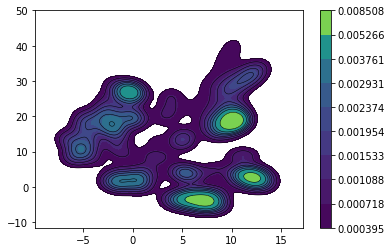

In [19]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=latent_space[:,:,0][:,0],
            y=latent_space[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=latent_space[:,:,0][:,0], 
            y=latent_space[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

<Axes: ylabel='Density'>

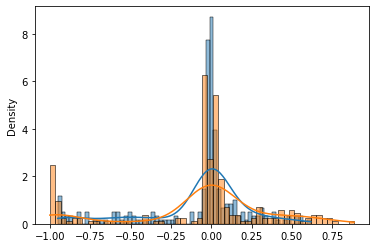

In [23]:
import seaborn as sns

sns.histplot(angles_re[1500][0],kde=True,stat='density')
sns.histplot(angles_300[1500],kde=True,stat='density')



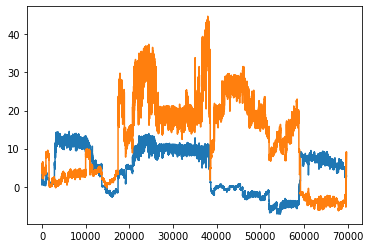

In [24]:
plt.plot(latent_space[:,:,0])
plt.plot(latent_space[:,:,1])

In [28]:
## T=350

laten_dim=[]
angle_re=[]

for j,i in enumerate(data_350):
    laten=loaded_ae.encoder(i)
    angle_back=loaded_ae.decoder(laten)
    laten_dim.append(laten.detach().numpy()) 
    angle_re.append(angle_back.detach().numpy())
    
latent_space_350 = np.array(laten_dim)
angles_re_350=np.array(angle_re)

<Axes: >

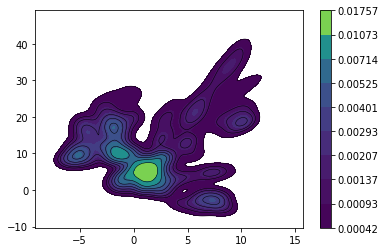

In [29]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=latent_space_350[:,:,0][:,0],
            y=latent_space_350[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=latent_space_350[:,:,0][:,0], 
            y=latent_space_350[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

In [30]:
## T=350

laten_dim=[]
angle_re=[]

for j,i in enumerate(data_500):
    laten=loaded_ae.encoder(i)
    angle_back=loaded_ae.decoder(laten)
    laten_dim.append(laten.detach().numpy()) 
    angle_re.append(angle_back.detach().numpy())
    
latent_space_500 = np.array(laten_dim)
angles_re_500=np.array(angle_re)

<Axes: >

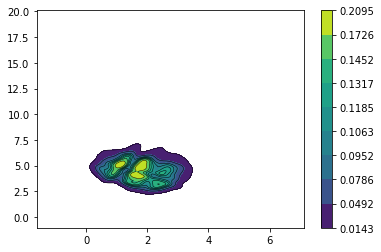

In [31]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=latent_space_500[:,:,0][:,0],
            y=latent_space_500[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=latent_space_500[:,:,0][:,0], 
            y=latent_space_500[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

# Trash

In [139]:
laten_400=[]

for i in data_400:
    x=vae.encoding_fn(x=i)
    laten_400.append(x.detach().numpy()) 
    
laten_400 = np.array(laten_400)

<Axes: >

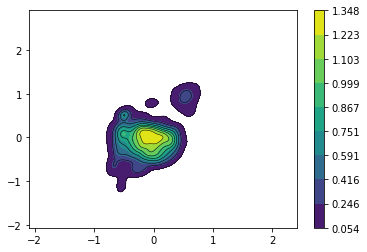

In [140]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=laten_400[:,:,0][:,0],
            y=laten_400[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=laten_400[:,:,0][:,0], 
            y=laten_400[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

In [142]:
t
       

In [143]:
laten_500=[]

for i in data_500:
    x=vae.encoding_fn(x=i)
    laten_500.append(x.detach().numpy()) 
    
laten_500 = np.array(laten_500)

<Axes: >

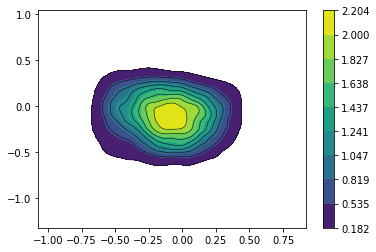

In [144]:
import seaborn as sns

fig, ax = plt.subplots()

sns.kdeplot(x=laten_500[:,:,0][:,0],
            y=laten_500[:,:,1][:,0],
            cmap="viridis",
            fill=True, 
            cbar=True,
            ax=ax)

# Add contour lines
sns.kdeplot(x=laten_500[:,:,0][:,0], 
            y=laten_500[:,:,1][:,0], 
            levels=9, 
            colors='k', 
            linewidths=0.5, 
            ax=ax)

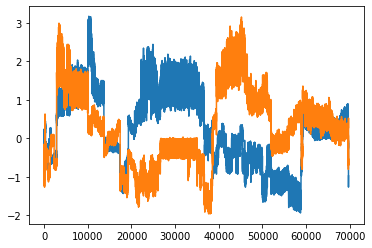

In [120]:
plt.plot(latent_space[:,:,0])
plt.plot(latent_space[:,:,1])

In [153]:
re_300.shape

(69738, 1, 252)

In [150]:
laten_300,re_300=runing_model(data_plot)

<Axes: ylabel='Density'>

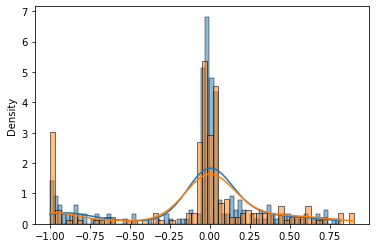

In [156]:
import seaborn as sns

sns.histplot(re_300[2000][0],kde=True,stat='density')
sns.histplot(angles_300[2000],kde=True,stat='density')